In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from transformers import ViTForImageClassification, ViTMAEConfig, ViTConfig, ViTMAEModel, ViTImageProcessor, TrainingArguments, Trainer
from PIL import Image
import matplotlib.pyplot as plt
import requests
from datasets import load_dataset
import torch
import numpy as np
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device


/home/jiachenyuan/miniconda3/envs/cs444env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda:0'

In [2]:
def count_model_size(model):
    size = 0
    for name, param in model.named_parameters():
        size += param.numel()
    return size

In [3]:
vit_classifier = ViTForImageClassification.from_pretrained('facebook/vit-mae-base', num_labels=10)
count_model_size(vit_classifier)

You are using a model of type vit_mae to instantiate a model of type vit. This is not supported for all configurations of models and can yield errors.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/vit-mae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


85806346

In [58]:
model = torchvision.models.resnet152(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)
count_model_size(model)


/home/jiachenyuan/miniconda3/envs/cs444env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


58164298

In [5]:
transform = transforms.Compose(
    [transforms.Resize(224),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                          shuffle=True, num_workers=4)

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

testset = torchvision.datasets.CIFAR10(root='./cifar10', train=False,
                                       download=True, transform=transform_test)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
for param in model.parameters():
    param.requires_grad = False
for name, param in model.fc.named_parameters():
    param.requires_grad = True

# Check if only the last layer is tunable
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)


model = model.to(device)

fc.weight
fc.bias


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.fc.parameters(), lr=0.001)
num_epochs = 9
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.8)

In [8]:
def evaluate_model(loader):
    num_correct = 0
    total = 0
    eval_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(loader, 0), total=len(loader)):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels).item()
            eval_loss += loss
            prediction = outputs.argmax(dim=-1)

            total += prediction.size(0)
            num_correct += (prediction == labels).sum().item()
    return eval_loss/len(loader), num_correct / total


In [14]:
train_losses = []
test_losses = []
test_acc = []

In [17]:
train_losses = np.load('train_losses.npy').tolist()
test_losses = np.load('test_losses.npy').tolist()
test_acc= np.load('test_correctness.npy').tolist()

In [18]:
# Train
train_loss_count_freq = 100
test_loss_min = np.Inf
for epoch in range(num_epochs):  # loop over the dataset multiple times
    model.train()
    # avg_train_loss = 0.0
    train_loss_buffer = []
    for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss_buffer.append(loss.item())
        if i % train_loss_count_freq == (train_loss_count_freq - 1):
            mean_train_loss = np.mean(train_loss_buffer)
            print(f'[{epoch + 1}, {i + 1:5d}] train loss: {mean_train_loss}')
            train_losses.append(mean_train_loss)
            train_loss_buffer.clear()
    
    
    # Evaluate on validation and test set
    model.eval()
    test_loss, correctness_test = evaluate_model(testloader)

    test_losses.append(test_loss)
    test_acc.append(correctness_test)

    # avg_train_loss = 0.0    
    print(f'[{epoch + 1}, {i + 1:5d}] train loss: {train_losses[-1]:.3f}, valid_loss: {test_loss:.3f}, acc: {correctness_test*100}%, lr={optimizer.param_groups[0]["lr"]}')

    # save model if validation loss has decreased
    if test_loss <= test_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        test_loss_min,
        test_loss))
        
        torch.save(model.state_dict(), 'model_cifar.pt')
        test_loss_min = test_loss

    train_losses_t = np.array(train_losses)
    test_losses_t = np.array(test_losses)
    np.save('train_losses.npy', train_losses_t)
    np.save('test_losses.npy', test_losses_t)
    np.save('test_correctness.npy', test_acc)

    scheduler.step()

print('Finished Training')

 26%|██▌       | 100/391 [00:39<01:49,  2.66it/s]

[1,   100] train loss: 0.4320884197950363


 51%|█████     | 200/391 [01:18<01:12,  2.62it/s]

[1,   200] train loss: 0.4278979414701462


 77%|███████▋  | 300/391 [01:56<00:34,  2.63it/s]

[1,   300] train loss: 0.42404757454991343


100%|██████████| 79/79 [00:29<00:00,  2.71it/s]


[1,   391] train loss: 0.424, valid_loss: 0.437, acc: 85.49%, lr=0.0008
Validation loss decreased (inf --> 0.436603).  Saving model ...


 26%|██▌       | 100/391 [00:39<01:54,  2.54it/s]

[2,   100] train loss: 0.40517410054802894


 51%|█████     | 200/391 [01:19<01:15,  2.54it/s]

[2,   200] train loss: 0.42052534893155097


 77%|███████▋  | 300/391 [01:59<00:36,  2.52it/s]

[2,   300] train loss: 0.41242741137742994


100%|██████████| 79/79 [00:29<00:00,  2.65it/s]

[2,   391] train loss: 0.412, valid_loss: 0.442, acc: 84.99%, lr=0.0008



 26%|██▌       | 100/391 [00:41<02:00,  2.42it/s]

[3,   100] train loss: 0.4081244701147079


 51%|█████     | 200/391 [01:21<01:16,  2.50it/s]

[3,   200] train loss: 0.4147764293849468


 77%|███████▋  | 300/391 [02:02<00:36,  2.49it/s]

[3,   300] train loss: 0.41543546989560126


100%|██████████| 79/79 [00:29<00:00,  2.65it/s]


[3,   391] train loss: 0.415, valid_loss: 0.434, acc: 85.39%, lr=0.0008
Validation loss decreased (0.436603 --> 0.433541).  Saving model ...


 26%|██▌       | 100/391 [00:41<01:57,  2.47it/s]

[4,   100] train loss: 0.3988069388270378


 51%|█████     | 200/391 [01:22<01:17,  2.46it/s]

[4,   200] train loss: 0.4235874292254448


 77%|███████▋  | 300/391 [02:02<00:36,  2.48it/s]

[4,   300] train loss: 0.41878817319869993


100%|██████████| 79/79 [00:29<00:00,  2.64it/s]


[4,   391] train loss: 0.419, valid_loss: 0.428, acc: 85.17%, lr=0.0008
Validation loss decreased (0.433541 --> 0.427760).  Saving model ...


 26%|██▌       | 100/391 [00:40<01:49,  2.65it/s]

[5,   100] train loss: 0.396138679087162


 51%|█████     | 200/391 [01:22<01:20,  2.37it/s]

[5,   200] train loss: 0.39787976622581483


 64%|██████▍   | 252/391 [01:44<00:57,  2.41it/s]


KeyboardInterrupt: 

In [11]:
model.eval()
evaluate_model(testloader)

  0%|          | 0/79 [00:00<?, ?it/s]

100%|██████████| 79/79 [00:25<00:00,  3.07it/s]


(0.4535290289528762, 0.8433)

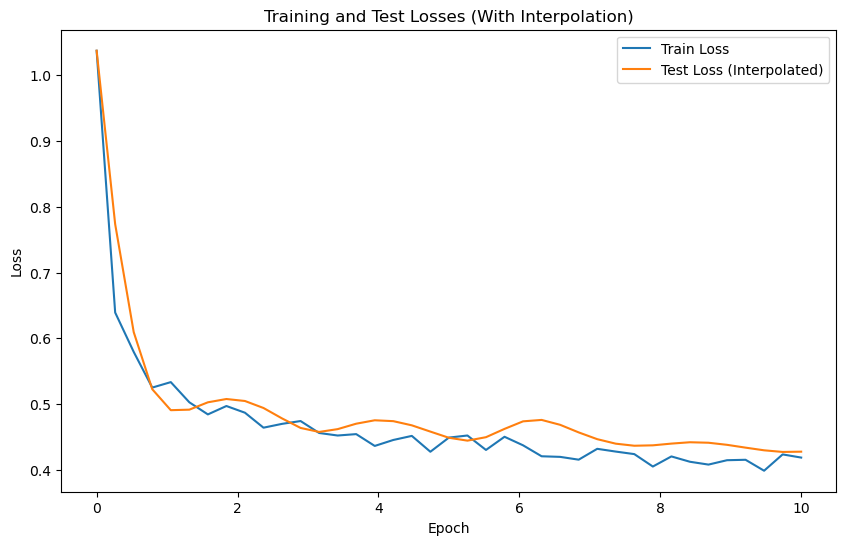

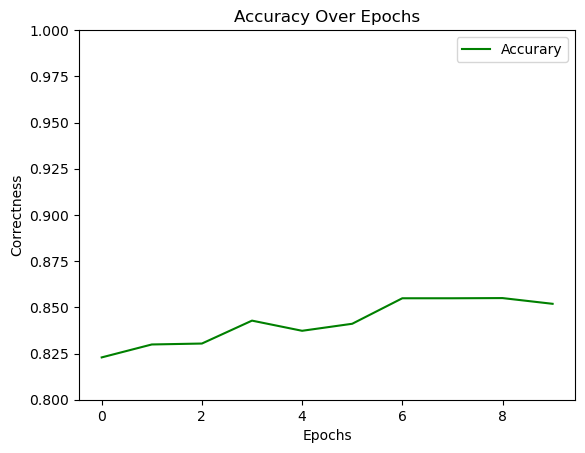

In [55]:
from scipy.interpolate import interp1d
from scipy.ndimage import uniform_filter1d

train_losses = np.load('train_losses.npy')
test_losses = np.load('test_losses.npy')
test_acc = np.load('test_correctness.npy')

test_losses = np.insert(test_losses, 0, train_losses[0])
len_train_losses = len(train_losses)
len_test_losses = len(test_losses)

# Interpolating the test losses
x_rescaled = np.linspace(0, 10, num=len_train_losses)
x_test = np.linspace(0, len_train_losses-1, num=len_test_losses) # Original x-axis for test losses
f = interp1d(x_test, test_losses, kind='cubic')
x_new = np.arange(0, len_train_losses) # New x-axis for interpolated test losses
test_losses_interp = f(x_new)

# Plotting the interpolated test losses with the train losses
plt.figure(figsize=(10, 6))
plt.plot(x_rescaled, train_losses, label='Train Loss')
plt.plot(x_rescaled, test_losses_interp, label='Test Loss (Interpolated)')
plt.title('Training and Test Losses (With Interpolation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.xlim(0, 10)
plt.legend()
plt.show()

# # Plotting the accuracy
# plt.figure(figsize=(10, 6))
# test_acc = np.insert(test_acc, 0, 0.75)
# f_acc = interp1d(x_test, test_acc, kind='cubic')
# test_acc_interp = f_acc(x_new)


# print(len(x_rescaled), len(test_acc_interp))
window_size = 1 
test_correctness_smoothed = uniform_filter1d(test_acc, size=window_size, mode='nearest')
plt.plot(test_correctness_smoothed, label='Accurary', color='green')

# Adding title and labels
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Correctness')
plt.ylim(0.8, 1)
# plt.xlim(0, 10)
# Adding legend
plt.legend()

# Show the plot
plt.show()


